In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pydicom
import skimage
from matplotlib.pyplot import figure
from itertools import chain
random_state = 42

This EDA should help to inform of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1.  [Downloading & Prepping Data](#0)<br>
2.  [The Patient Demographic Distribution](#2)<br>
3.  [View Position](#2)<br>
4.  [The Number of Cases](#2)<br>
5.  [The Distribution Diseases Comorbid with Pneumonia](#4) <br>
6.  [Number of Disease Per Patient](#6) <br>
7.  [Pixel-level assessments](#8) <br>

## 1. Downloading & Prepping Data

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3269,00016124_003.png,Infiltration,3,16124,046Y,F,PA,2500,2836,0.143,0.143
1201,00006338_002.png,Mass,2,6338,053Y,F,AP,2500,2048,0.171,0.171
1550,00008040_003.png,No Finding,3,8040,043Y,F,AP,2500,2048,0.171,0.171


In [3]:
## explore the dataset
all_xray_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


### Splitting the finding label to a column per each unique disease 

In [4]:
## get a list of all labes in the datset
All_Labels = np.unique(list(chain(*all_xray_df["Finding Labels"].map(lambda x: x.split("|")).tolist())))
All_Labels = [x for x in All_Labels if len(x)>0]
print("All Labels in Dataset Are ({}): {}".format(len(All_Labels), All_Labels))

All Labels in Dataset Are (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [5]:
## convert all diseases in the dataset to binary flag (1 for positive, 0 for negative)
for c_labels in All_Labels:
    if len(c_labels)>1:
        all_xray_df[c_labels] = all_xray_df["Finding Labels"].map(lambda finding: 1.0 if c_labels in finding else 0)
all_xray_df.head()        

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. The Patient Demographic Distribution

In [6]:
## get the percent of each label in the data set
Lables_percent = ((all_xray_df[All_Labels].sum()/len(all_xray_df)).to_frame()).reset_index()
Lables_percent.rename(columns = {'index':'Labels' ,0: 'percentage'}, inplace = True)
Lables_percent_sorted = Lables_percent.sort_values( by = 'percentage', ascending = False)

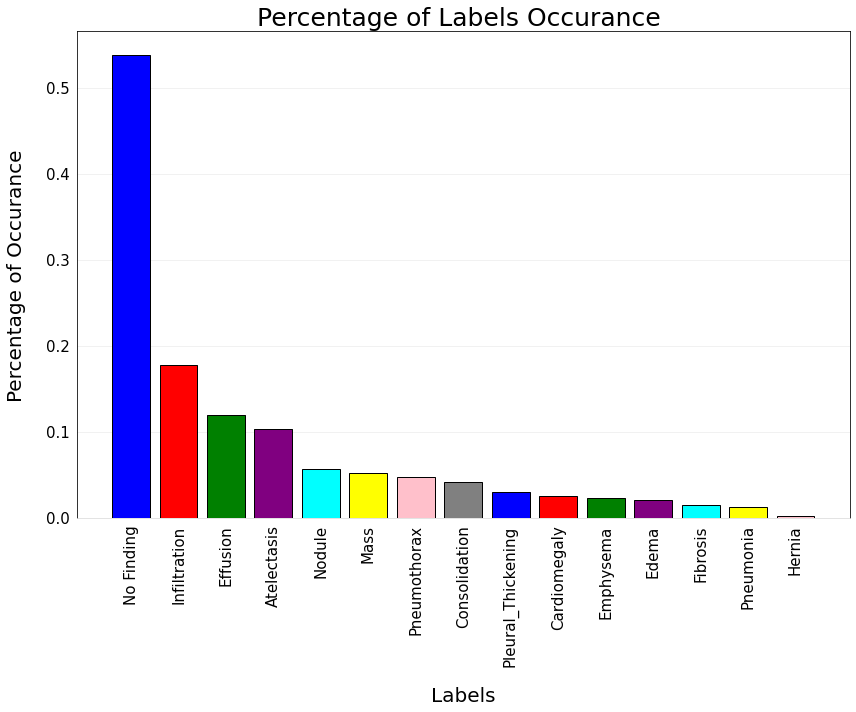

In [7]:
plt.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
bars = ax.bar(x=Lables_percent_sorted['Labels'] , height=Lables_percent_sorted['percentage'],
              color=['blue', 'red', 'green', 'purple', 'cyan', 'yellow','pink', 'grey'],edgecolor='black', width=0.8, tick_label= None)


# Save the chart so we can loop through the bars below.
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15 , rotation = 90)
plt.xlabel('Labels' ,labelpad= 20 ,fontsize = 20)
plt.ylabel('Percentage of Occurance' ,labelpad= 20, fontsize = 20)
plt.title('Percentage of Labels Occurance ', fontsize = 25 )

ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Make the chart fill out the figure better.
fig.tight_layout()

The relative frequencies of each disease shows that cases with (No Finding) cases are most occurance. for diseases frequency, Infiltration, Effusion, Nodule, and Atelectasis are the top 4 common diseases occured in the datasat.

In [8]:
## drop 'No Finding'  from the dataset
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
All_Labels = np.unique(list(chain(*all_xray_df["Finding Labels"].map(lambda x: x.split("|")).tolist())))
All_Labels = [x for x in All_Labels if len(x)>0]
print("All Labels in Dataset Are ({}): {}".format(len(All_Labels), All_Labels))
## convert all diseases in the dataset to binary flag (1 for positive, 0 for negative)
for c_labels in All_Labels:
    if len(c_labels)>1:
        all_xray_df[c_labels] = all_xray_df["Finding Labels"].map(lambda finding: 1.0 if c_labels in finding else 0)
all_xray_df.head() 

All Labels in Dataset Are (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Demographic Distribution by Age

In [9]:
## explore age range in the dataset
print ( "The maximum patient age in the dataset is : " , all_xray_df['Patient Age'].max(), "years old")

The maximum patient age in the dataset is :  414 years old


In [10]:
## Apply 120 years as age cut-off 
all_xray_df_fltrd = all_xray_df[all_xray_df["Patient Age"]<120]
print ( "The maximum patient age in the dataset is now : " , all_xray_df_fltrd['Patient Age'].max(), "years old")

The maximum patient age in the dataset is now :  95 years old


In [11]:
print ( "The minimum patient age in the dataset is : " , all_xray_df_fltrd['Patient Age'].min(), "years old")

The minimum patient age in the dataset is :  1 years old


Text(0.5, 1.0, 'Age Distribution Across Whole Dateset ')

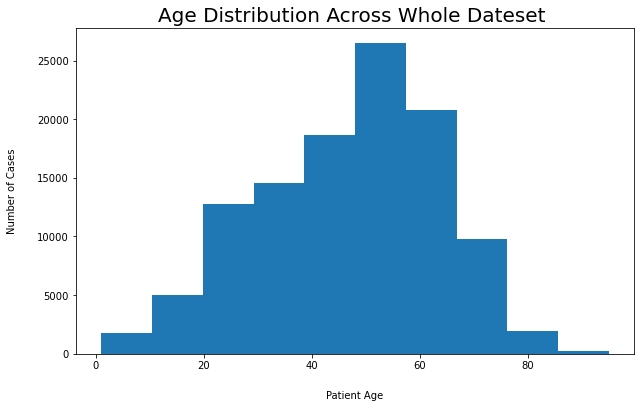

In [12]:
## age distribution across the whole population
plt.figure(figsize=(10,6))
plt.hist(all_xray_df_fltrd['Patient Age'])
plt.ylabel('Number of Cases' ,labelpad= 20, fontsize = 10)
plt.xlabel('Patient Age' ,labelpad= 20, fontsize = 10)
plt.title('Age Distribution Across Whole Dateset ', fontsize = 20 )

Age range of (1 to 95 years) distrbuted across the whole diseases in the dataset. However, The age range of 50-58 apears to be the peak of cases number.
In conclusion, patients aged 40-65 yraes are common for all diseases.

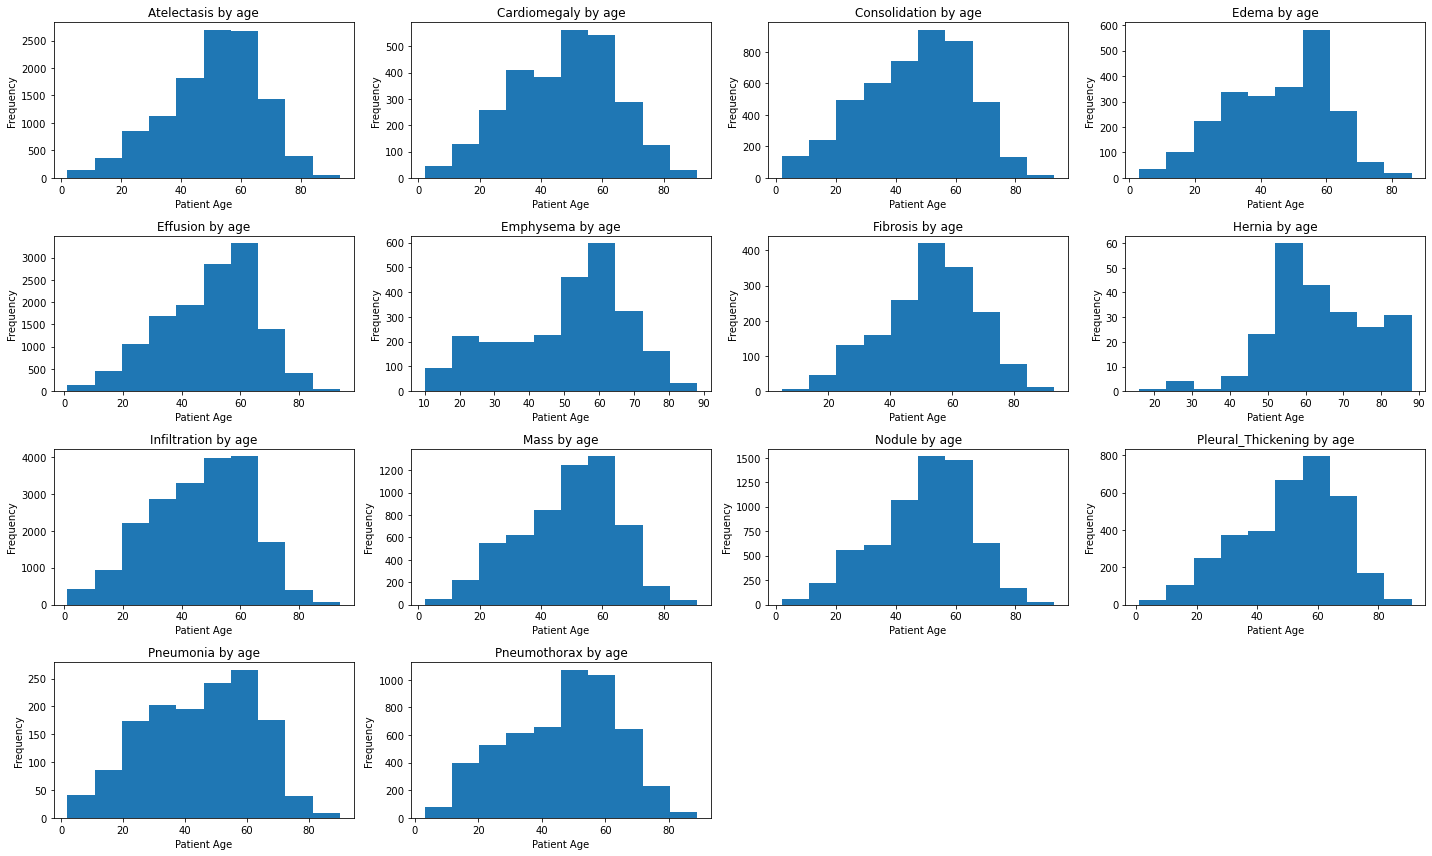

In [13]:
## age distribution for each label
fig = plt.subplots(figsize = (20, 12))
for ind, label in enumerate(All_Labels):
    plt.subplot(4, 4, ind+1)
    plt.hist(all_xray_df_fltrd[all_xray_df_fltrd[label] == 1.0]['Patient Age'])
    plt.xlabel('Patient Age')
    plt.ylabel('Frequency')
    plt.title('%s by age'%label)
    plt.tight_layout()

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

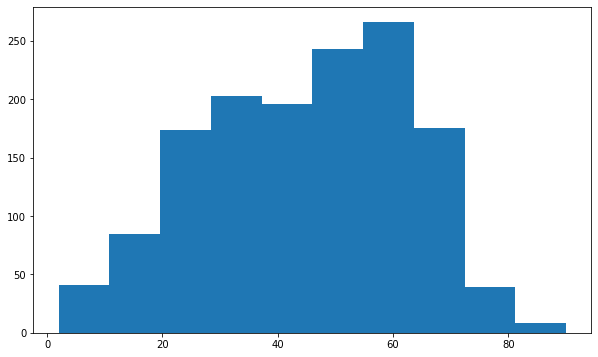

In [14]:
## age distribution for Pneumonia
plt.figure(figsize=(10,6))
plt.hist(all_xray_df_fltrd[all_xray_df_fltrd.Pneumonia==1]['Patient Age'])

Age distribution for all labels is slightly different. for Pneumonia, the age of 55- 65 age is the dominant for Pneumonia cases.

### Demographic Distribution by Gender

Text(0.5, 0, 'Gender')

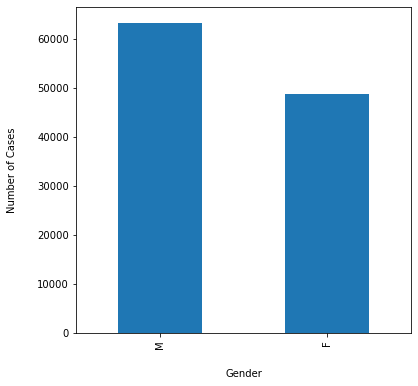

In [15]:
## Gender distribution across the whole population
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')
plt.ylabel('Number of Cases' ,labelpad= 20, fontsize = 10)
plt.xlabel('Gender' ,labelpad= 20, fontsize = 10)

For gender distribution across the dataset, it apears that mela patients more than females.

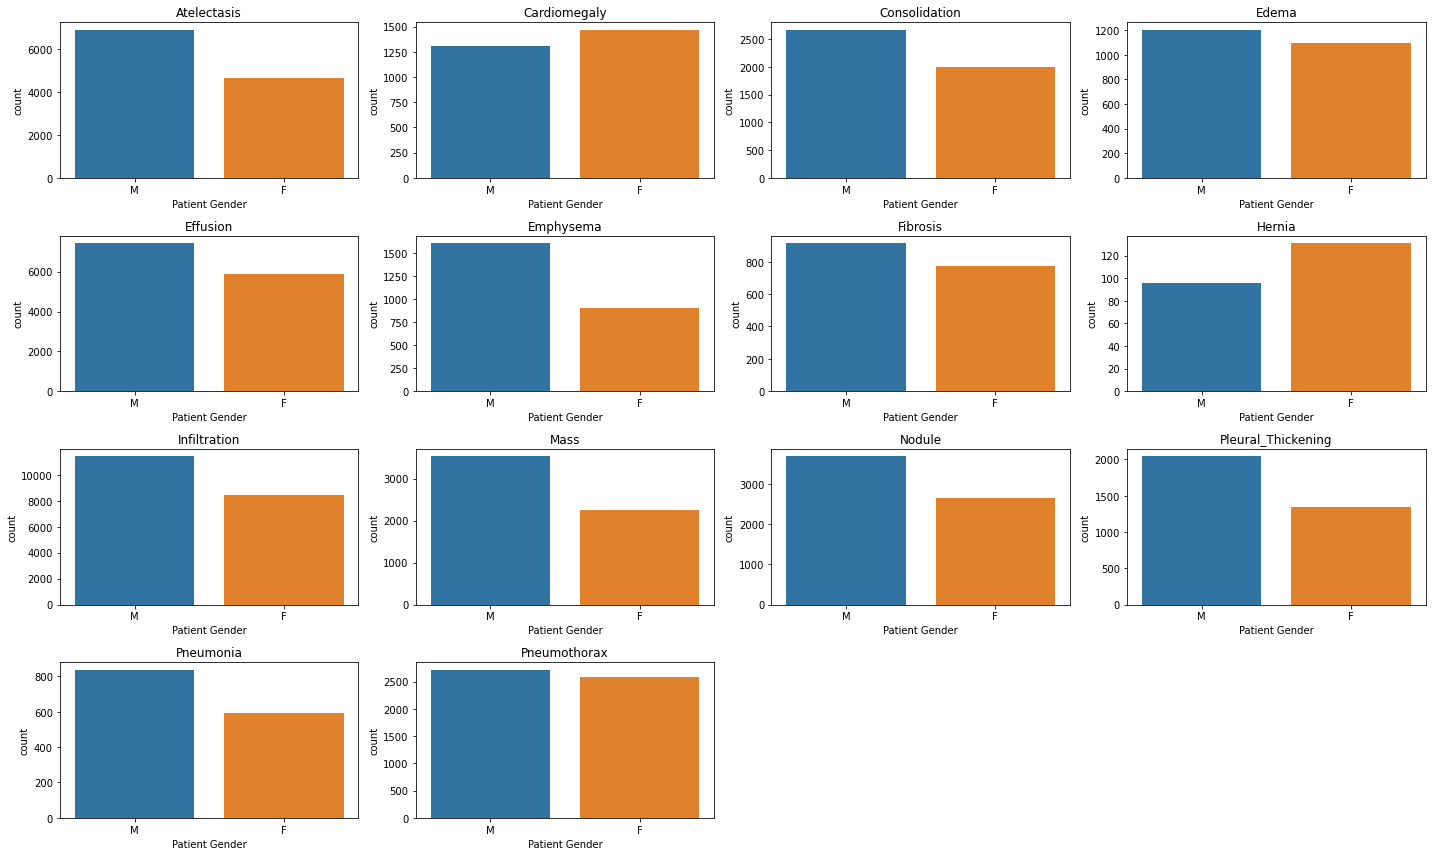

In [16]:
## gender distribution for each label
fig = plt.subplots(figsize = (20, 12))
for ind, label in enumerate(All_Labels):
    plt.subplot(4, 4, ind+1)
    ax = sns.countplot(x='Patient Gender',data = all_xray_df[all_xray_df[label] == 1], order=['M', 'F'])
    plt.title(label)
    plt.tight_layout()

It can be observed that male patients are more than females in all diseases except Cardiomegaly and Hernia. 

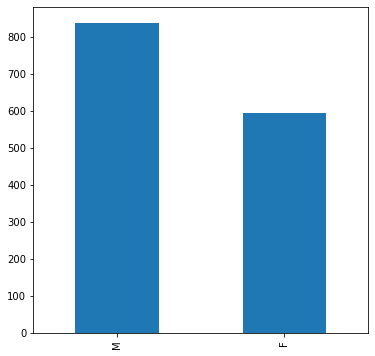

In [17]:
## gender distribution for Pneumonia
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia ==1]['Patient Gender'].value_counts().plot(kind='bar')

## 3. Distribution by  View Position

Text(0.5, 0, 'View Position')

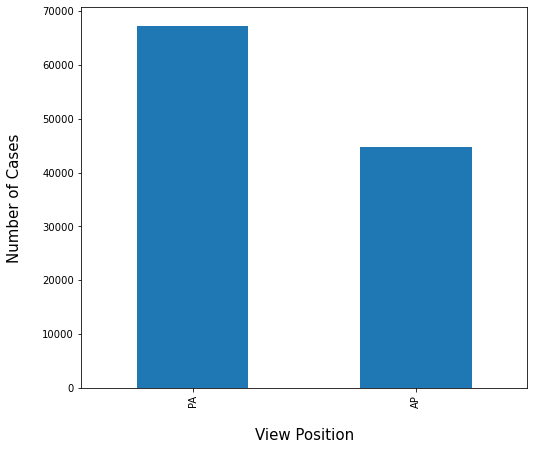

In [18]:
## Gender distribution across the whole population
plt.figure(figsize=(8,7))
all_xray_df['View Position'].value_counts().plot(kind='bar')
plt.ylabel('Number of Cases' ,labelpad= 20, fontsize = 15)
plt.xlabel('View Position' ,labelpad= 20, fontsize = 15)

The distribution shows that more cases are taken in PA position.

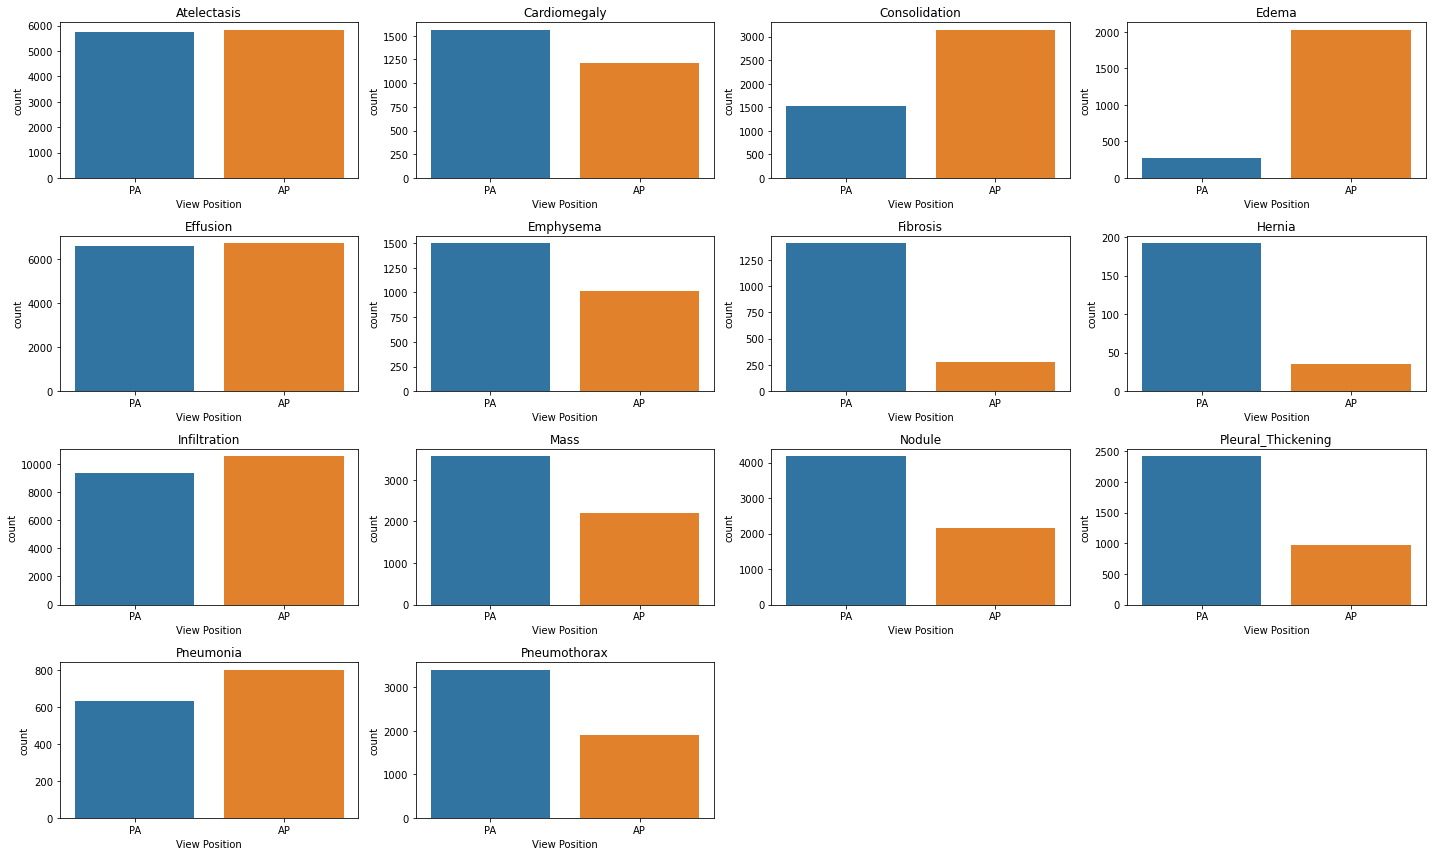

In [19]:
## view position distribution for each label
fig = plt.subplots(figsize = (20, 12))
for ind, label in enumerate(All_Labels):
    plt.subplot(4, 4, ind+1)
    ax = sns.countplot(x='View Position',data = all_xray_df[all_xray_df[label] == 1], order=['PA', 'AP'])
    plt.title(label)
    plt.tight_layout()

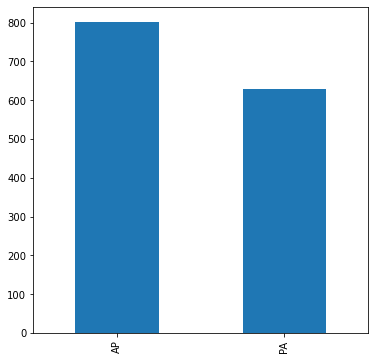

In [20]:
## view posotion distribution for Pneumonia
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia ==1]['View Position'].value_counts().plot(kind='bar')

For Pneumonia cases, more  x-ray views was taken by PA.

## 4. The Number of Cases 

### Number of non-pneumonia cases

In [21]:
## number of pneumonia cases
Non_Pneumonia_Cases = 0
for i in All_Labels:
        if i != 'Pneumonia':
            print('Number of %s cases = %d' %(i, all_xray_df[i].sum()))
            Non_Pneumonia_Cases += all_xray_df[i].sum()
print('\n')
print(" The total number of non-pneumonia cases = %d" %Non_Pneumonia_Cases)

Number of Atelectasis cases = 11559
Number of Cardiomegaly cases = 2776
Number of Consolidation cases = 4667
Number of Edema cases = 2303
Number of Effusion cases = 13317
Number of Emphysema cases = 2516
Number of Fibrosis cases = 1686
Number of Hernia cases = 227
Number of Infiltration cases = 19894
Number of Mass cases = 5782
Number of Nodule cases = 6331
Number of Pleural_Thickening cases = 3385
Number of Pneumothorax cases = 5302


 The total number of non-pneumonia cases = 79745


### Number of pneumonia cases

In [22]:
print('Number of pneumonia cases = %d'%all_xray_df['Pneumonia'].sum())

Number of pneumonia cases = 1431


## 5. The Distribution Diseases Comorbid with Pneumonia

Text(0.5, 1.0, ' Pneumonia Co-occurance ')

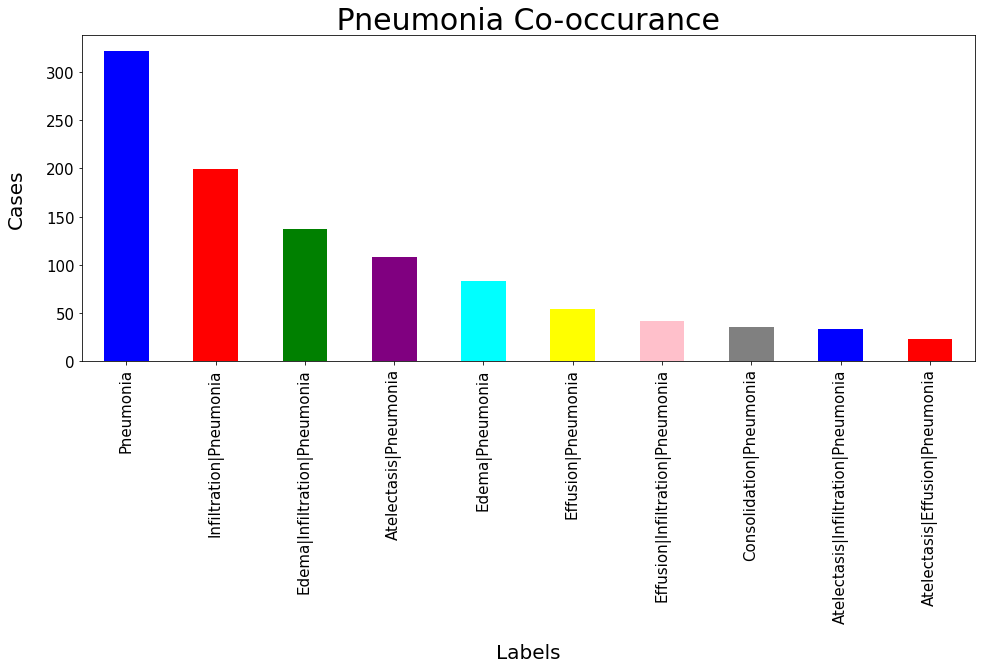

In [23]:
##Since there are many combinations of potential findings, I'm going to look at the 10 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:10].plot(kind='bar',
                                                                                  color=['blue', 'red', 'green', 'purple', 'cyan', 'yellow','pink', 'grey'])
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15 , rotation = 90)
plt.xlabel('Labels' ,labelpad= 20 ,fontsize = 20)
plt.ylabel('Cases' ,labelpad= 20, fontsize = 20)
plt.title(' Pneumonia Co-occurance ', fontsize = 30 )

It seems that Pneumonia actually occurs alone for the most part, and that its most-common comorbidities are Infiltration, Edema/Infiltration, Atelectasis, Edema and Effusion.

## 6. Number of Disease Per Patient

In [24]:
## group by patient ID
patient_grpd = all_xray_df.groupby(["Patient ID"])[All_Labels].sum()
patient_grpd["Number of Disease"] = patient_grpd.astype(bool).sum(axis=1)
patient_grpd.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number of Disease
Patient ID,,,,,,,,,,,,,,,
1,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2


In [25]:
patient_per_disease = patient_grpd.groupby("Number of Disease").size().to_frame().reset_index()
patient_per_disease.rename(columns = {'Number of Disease':'Disease Counts' , 0 : 'Number of Petients'}, inplace = True)
patient_per_disease

,Disease Counts,Number of Petients
0,0,16403
1,1,6742
2,2,2908
3,3,1638
4,4,1087
5,5,707
6,6,518
7,7,335
8,8,205
9,9,139


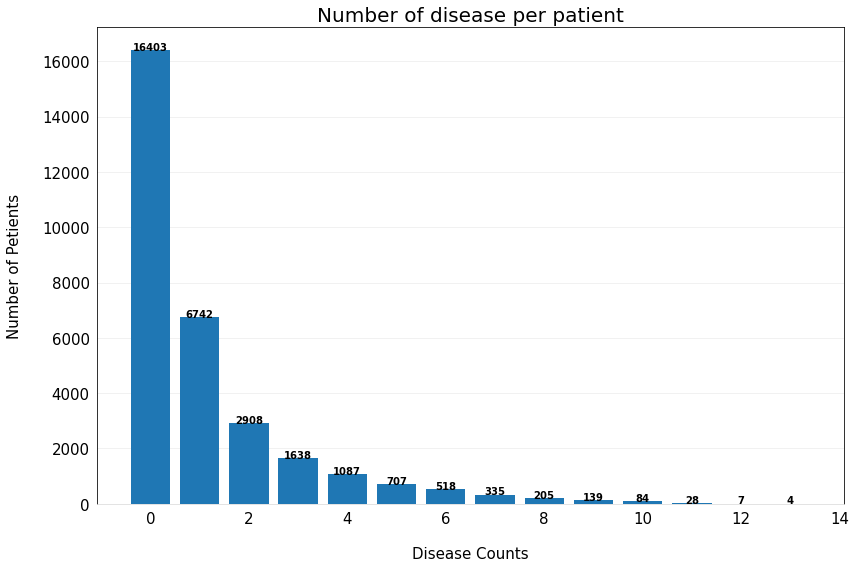

In [26]:
plt.rcParams['figure.figsize'] = (12, 8)
fig, ax = plt.subplots()
bars = ax.bar(x=patient_per_disease['Disease Counts'] , height=patient_per_disease['Number of Petients'], width=0.8, 
              tick_label= None)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15 , rotation = 0)
plt.xlabel('Disease Counts' ,labelpad= 20 ,fontsize = 15)
plt.ylabel('Number of Petients' ,labelpad= 20, fontsize = 15)
plt.title('Number of disease per patient', fontsize = 20 )
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 10),
      horizontalalignment='center',
      color="black",
      weight='bold'
  )

fig.tight_layout()

Patients with only one disease are common in the dataset with 6742 cases. and the number of patients decreases with number of multiple diseases co-occuring, for example, there are only 4 4 patients have 13 diseases.

## 7. Pixel-level assessments

In [27]:
## To get the image intensity, we need to first get the path of all images
sample_df = pd.read_csv('sample_labels.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 5606


In [28]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000032_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00030712_000.png
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000,/data/images_012/images/00030786_005.png
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00030789_000.png
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311,/data/images_012/images/00030792_000.png


In [29]:
## get a list of unique lanles list
sample_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
sample_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [30]:
## mean intensity all labels:
for item in sample_labels:
    img_path = sample_df[sample_df["Finding Labels"] == item].sample(5, random_state=random_state)["path"]
    mean_var_arr = np.mean([plt.imread(img_path.iloc[i]) for i in range(len(img_path.values))])
    print(f"The mean intensity value for {item} is {mean_var_arr}")

The mean intensity value for Atelectasis is 0.5028044581413269
The mean intensity value for Cardiomegaly is 0.5193173289299011
The mean intensity value for Consolidation is 0.5230416655540466
The mean intensity value for Edema is 0.4911823868751526
The mean intensity value for Effusion is 0.5089768171310425
The mean intensity value for Emphysema is 0.5837641954421997
The mean intensity value for Fibrosis is 0.5117815136909485
The mean intensity value for Hernia is 0.5753105878829956
The mean intensity value for Infiltration is 0.44429731369018555
The mean intensity value for Mass is 0.4767821431159973
The mean intensity value for No Finding is 0.5468572378158569
The mean intensity value for Nodule is 0.5582643747329712
The mean intensity value for Pleural_Thickening is 0.5034782290458679
The mean intensity value for Pneumonia is 0.513569712638855
The mean intensity value for Pneumothorax is 0.4420766234397888


Since it is not clear from the values, let's plot the intensity values

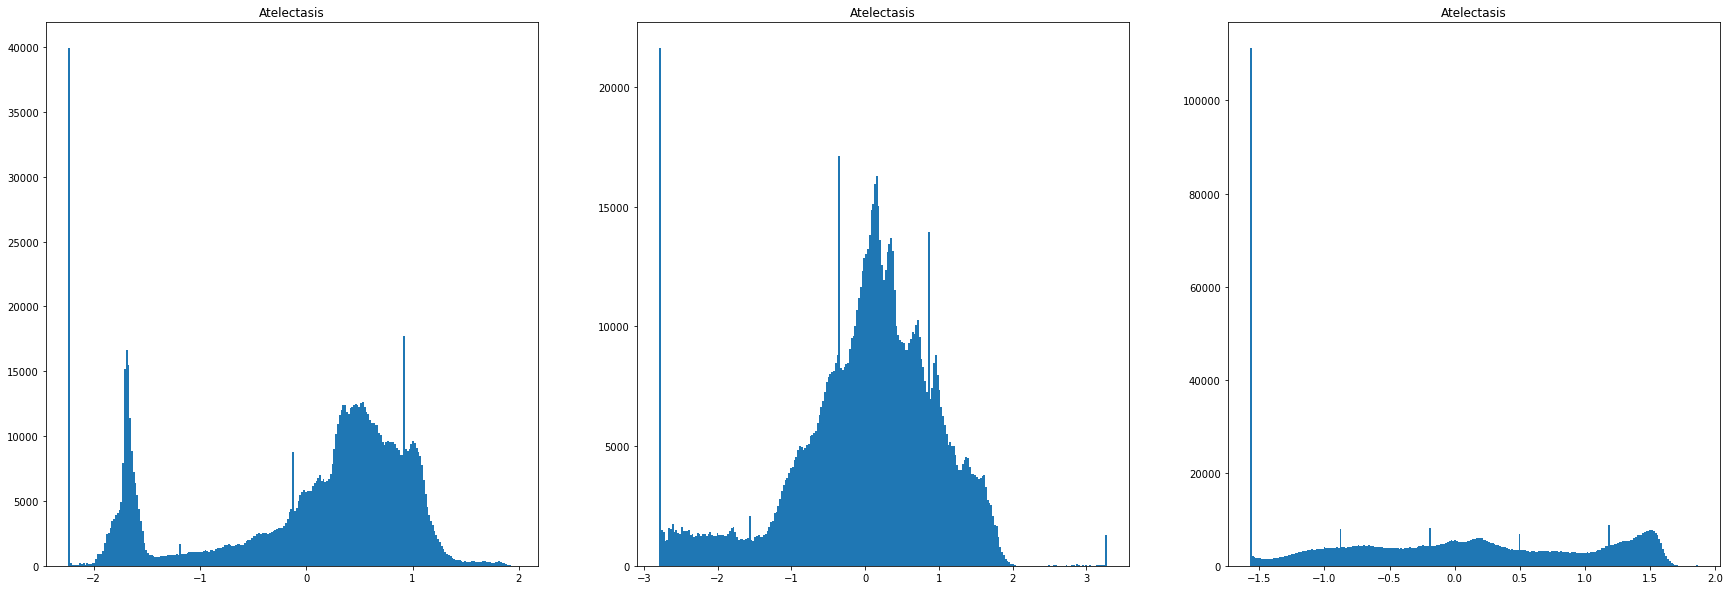

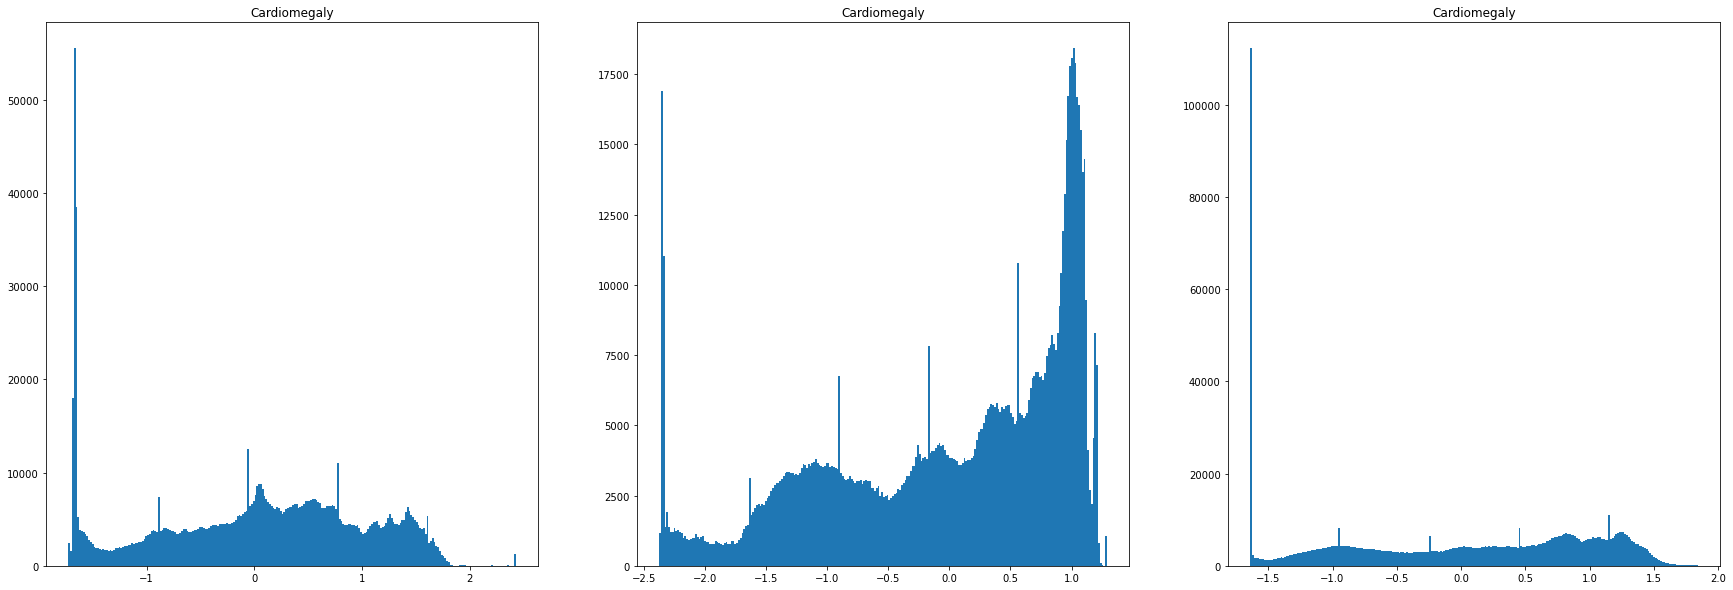

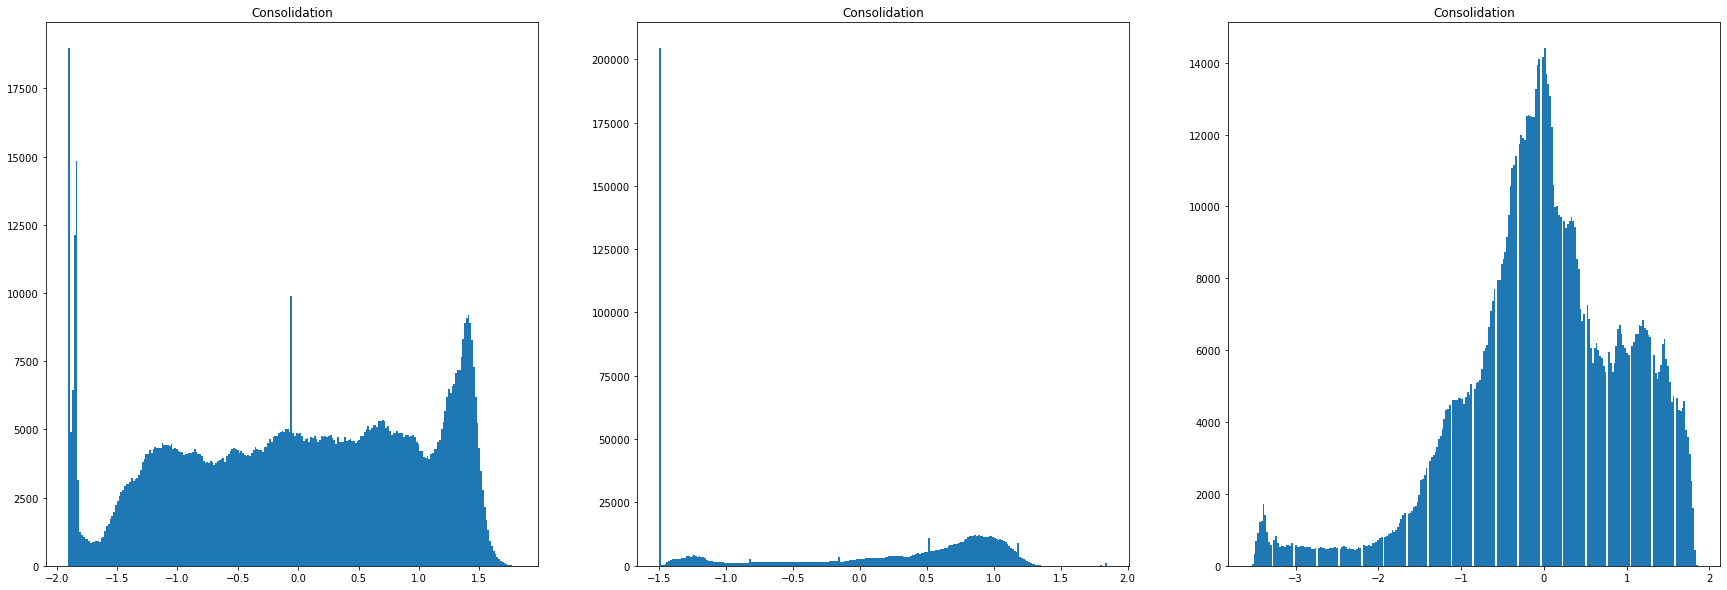

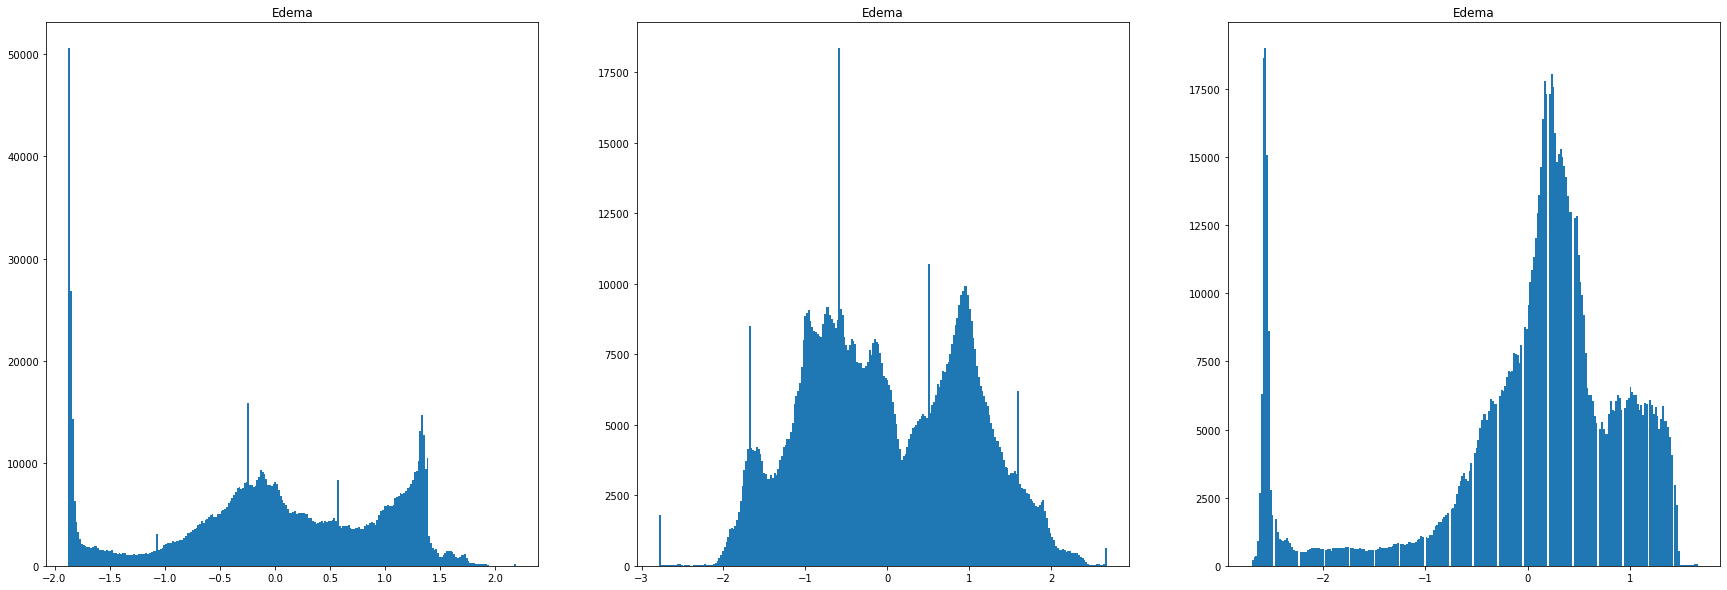

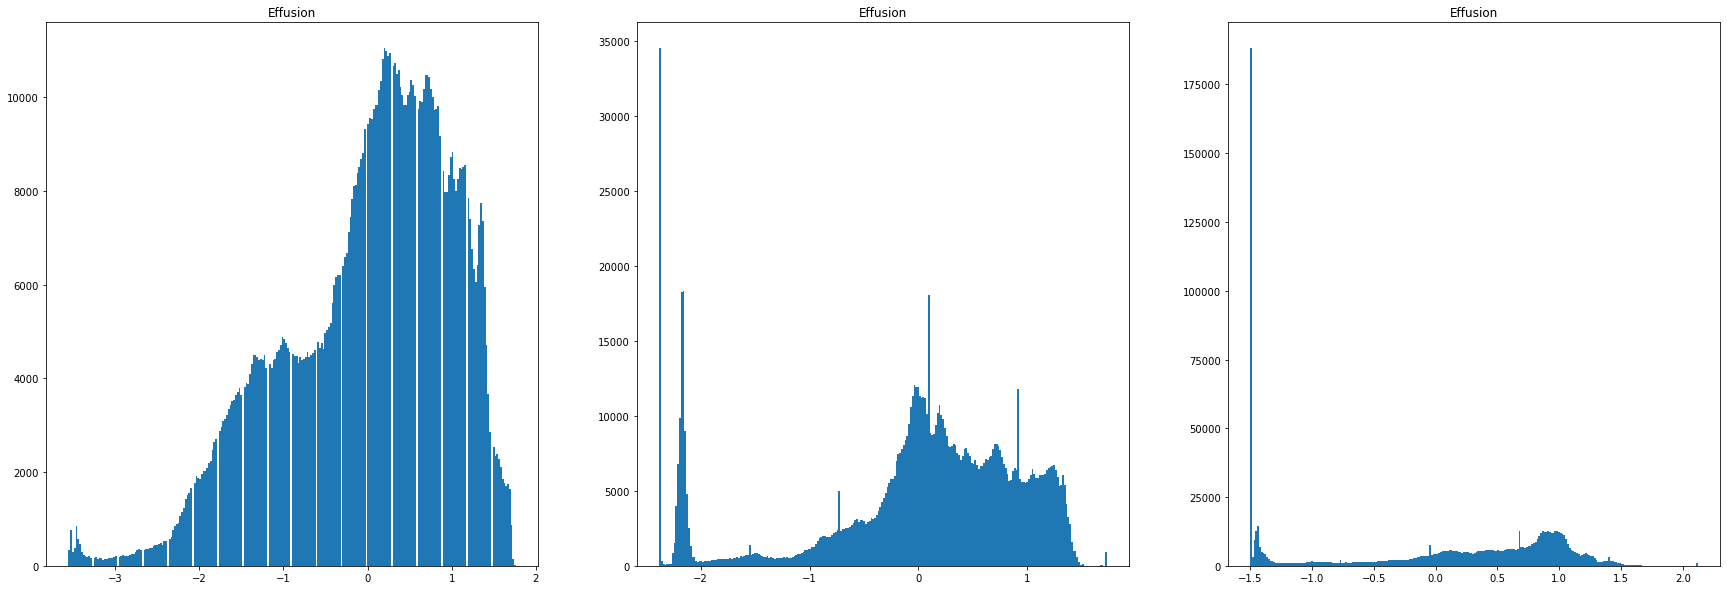

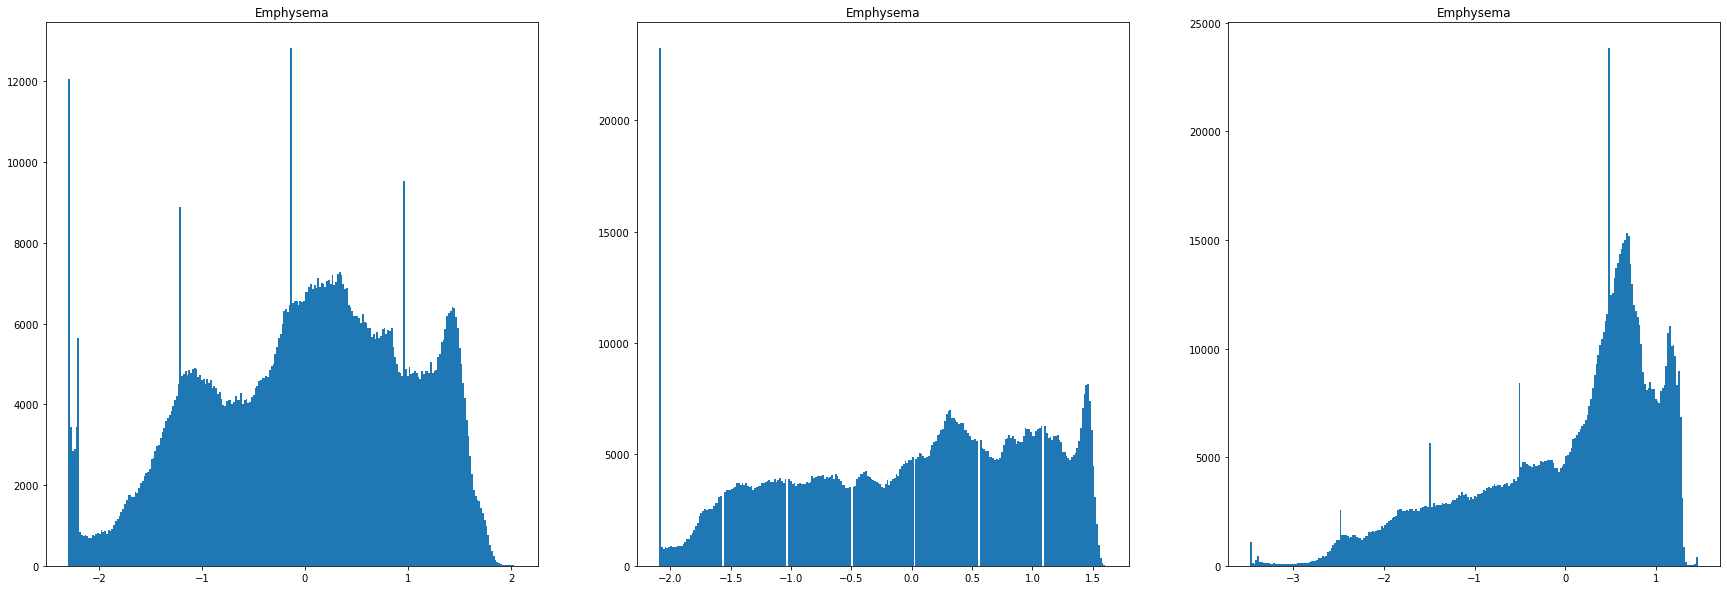

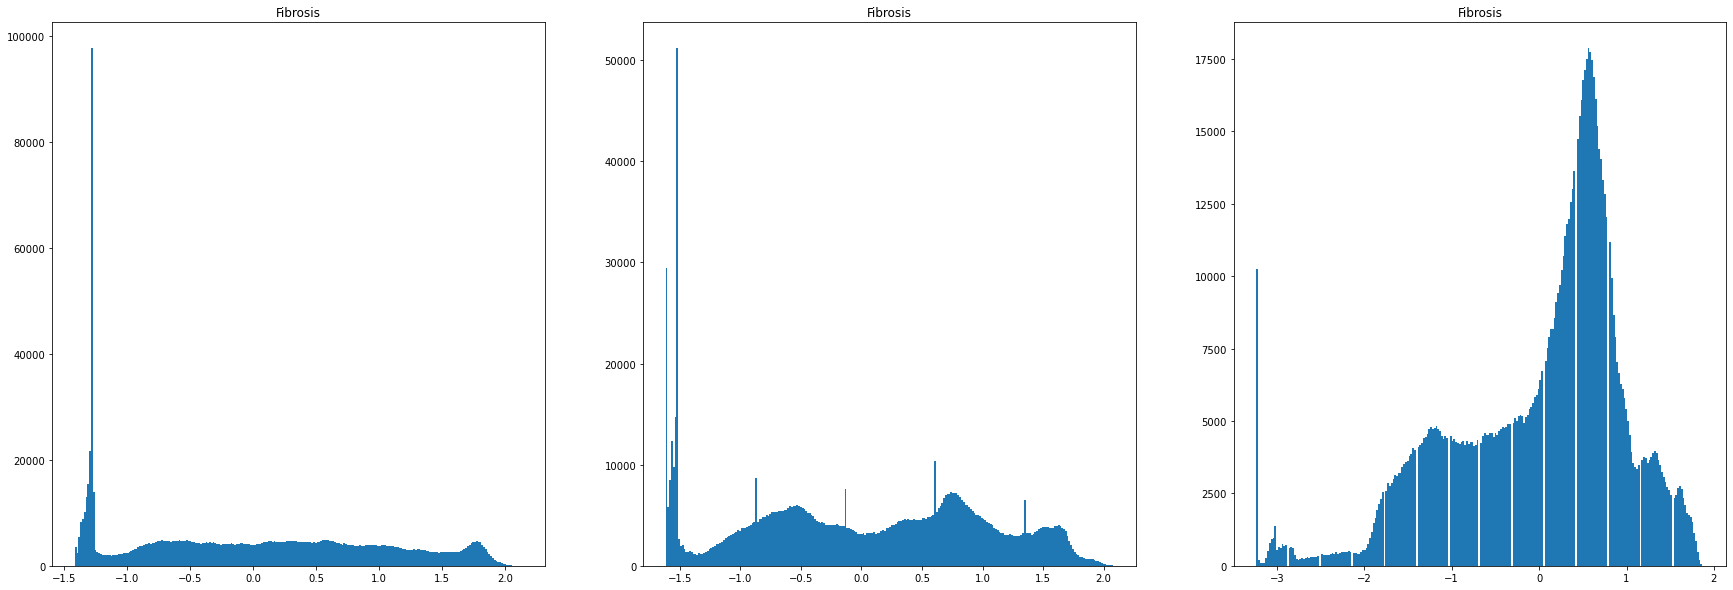

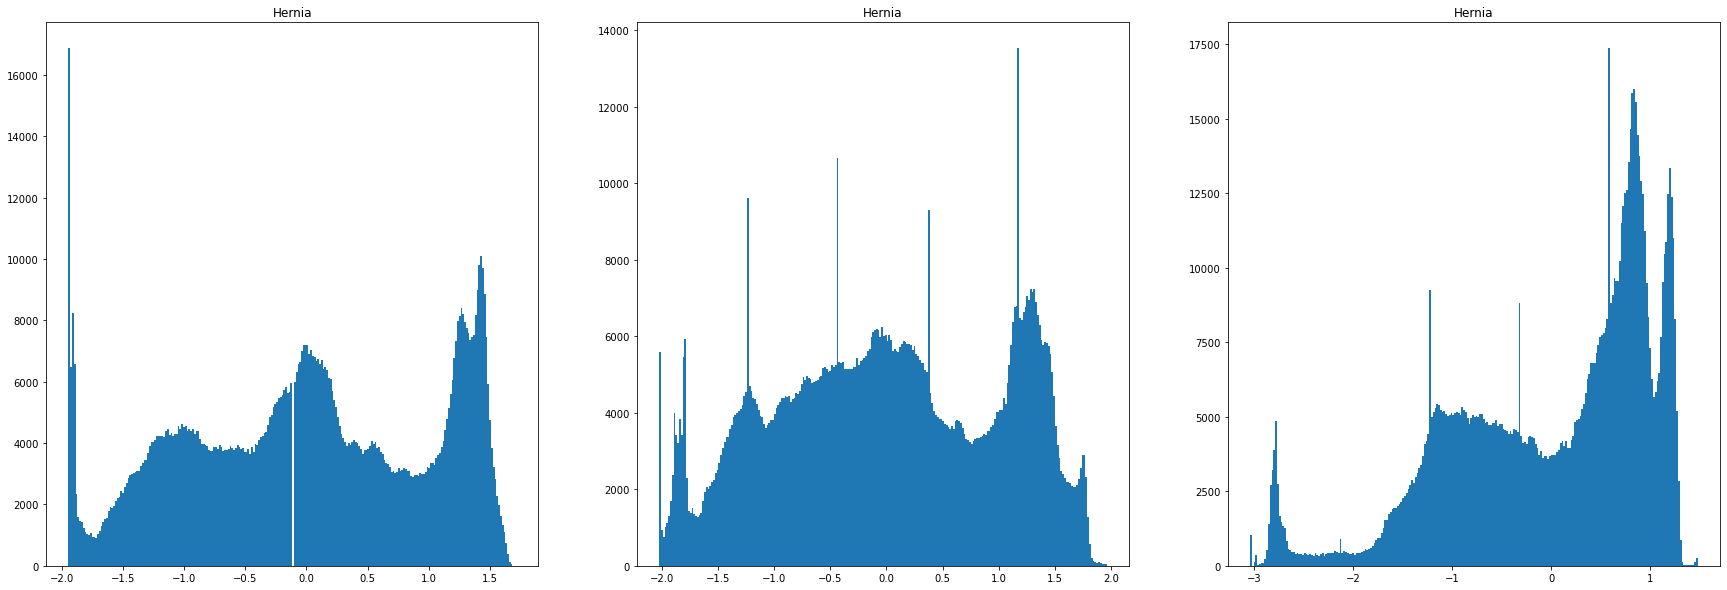

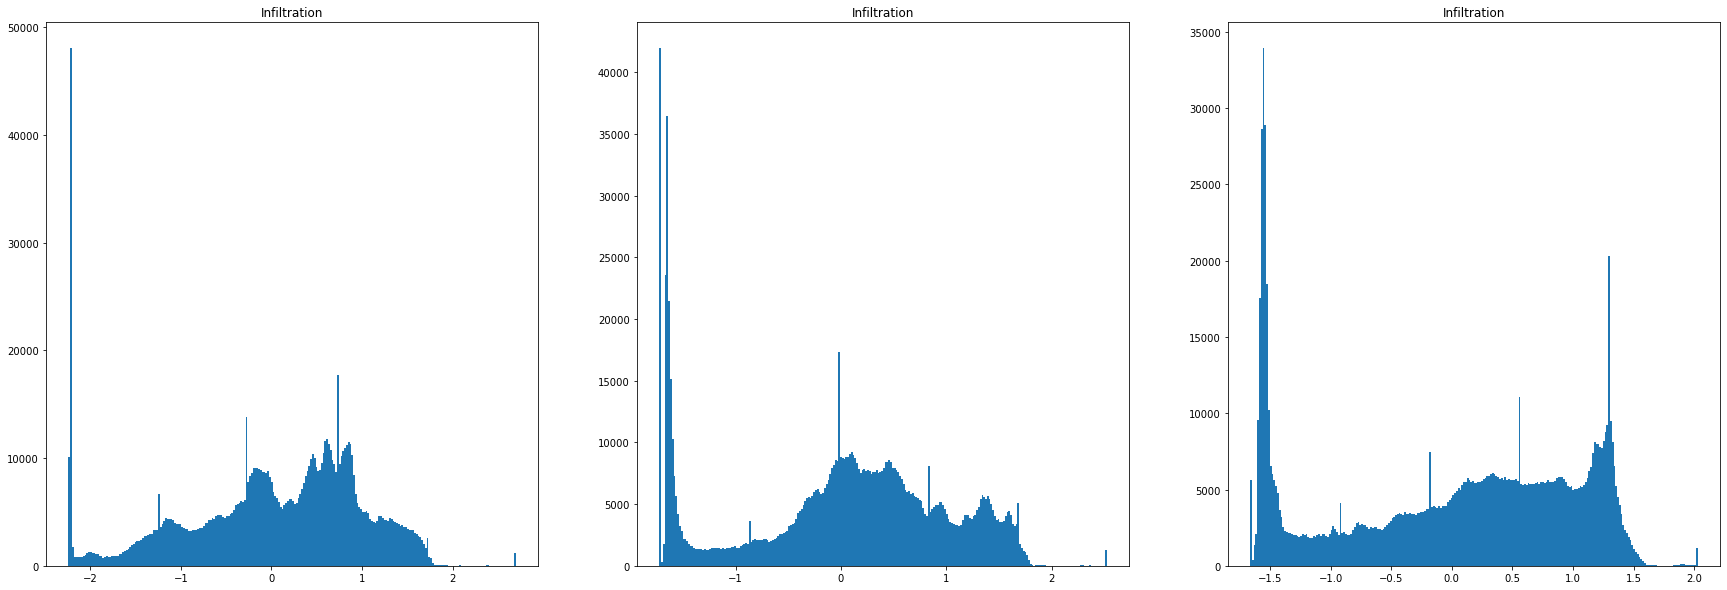

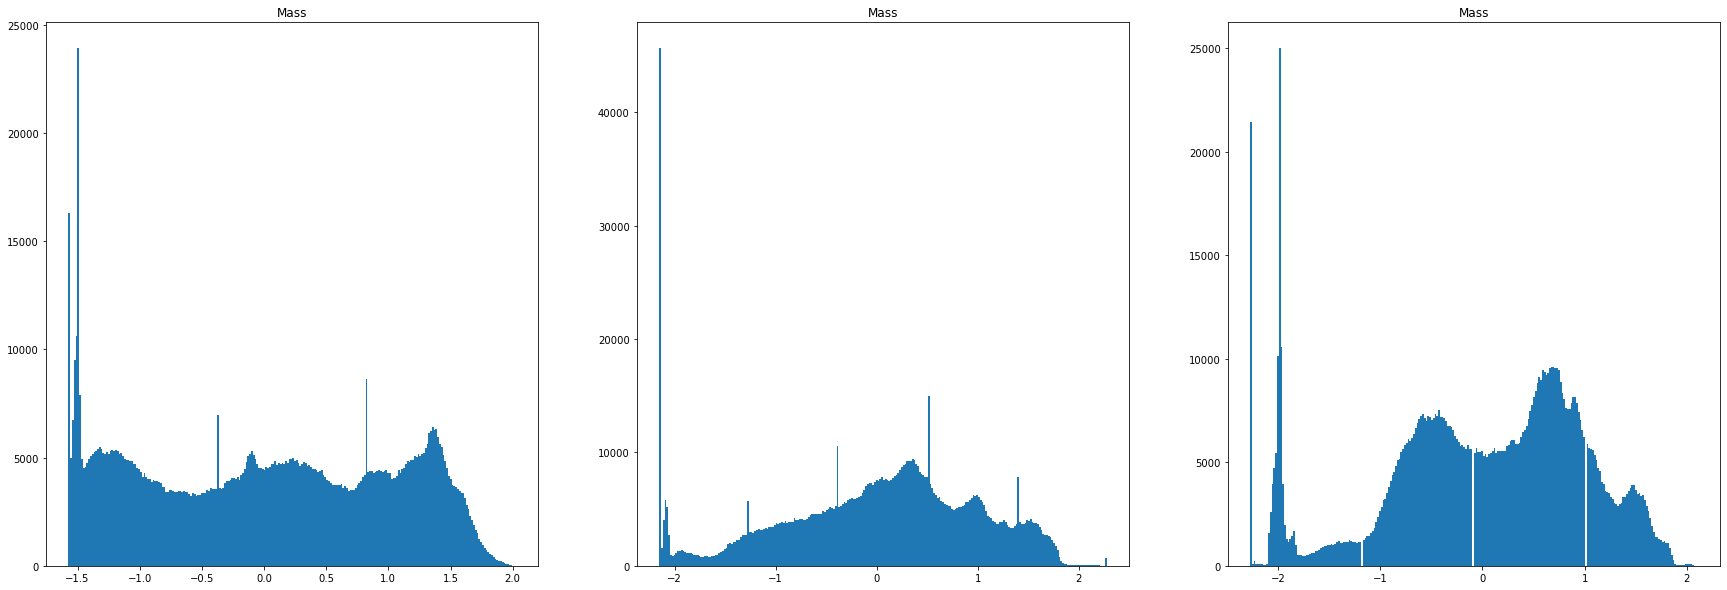

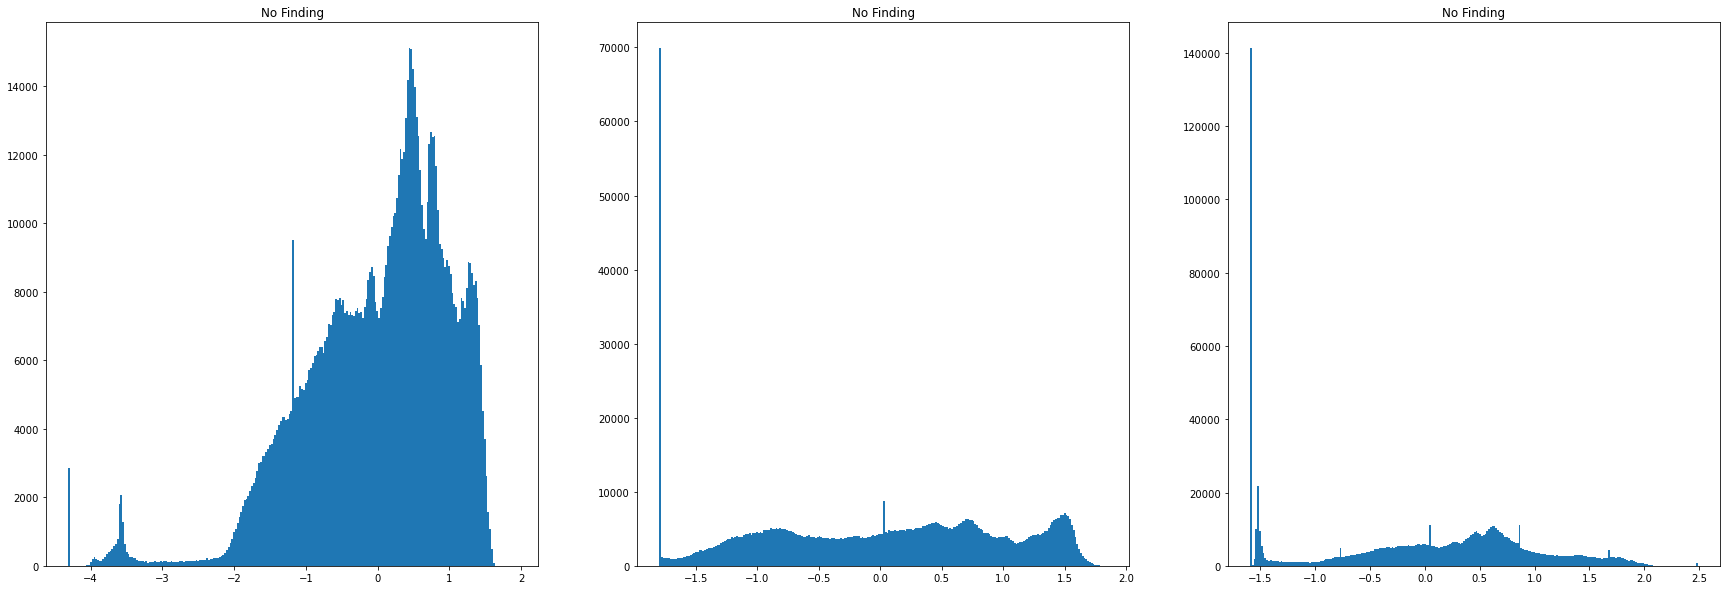

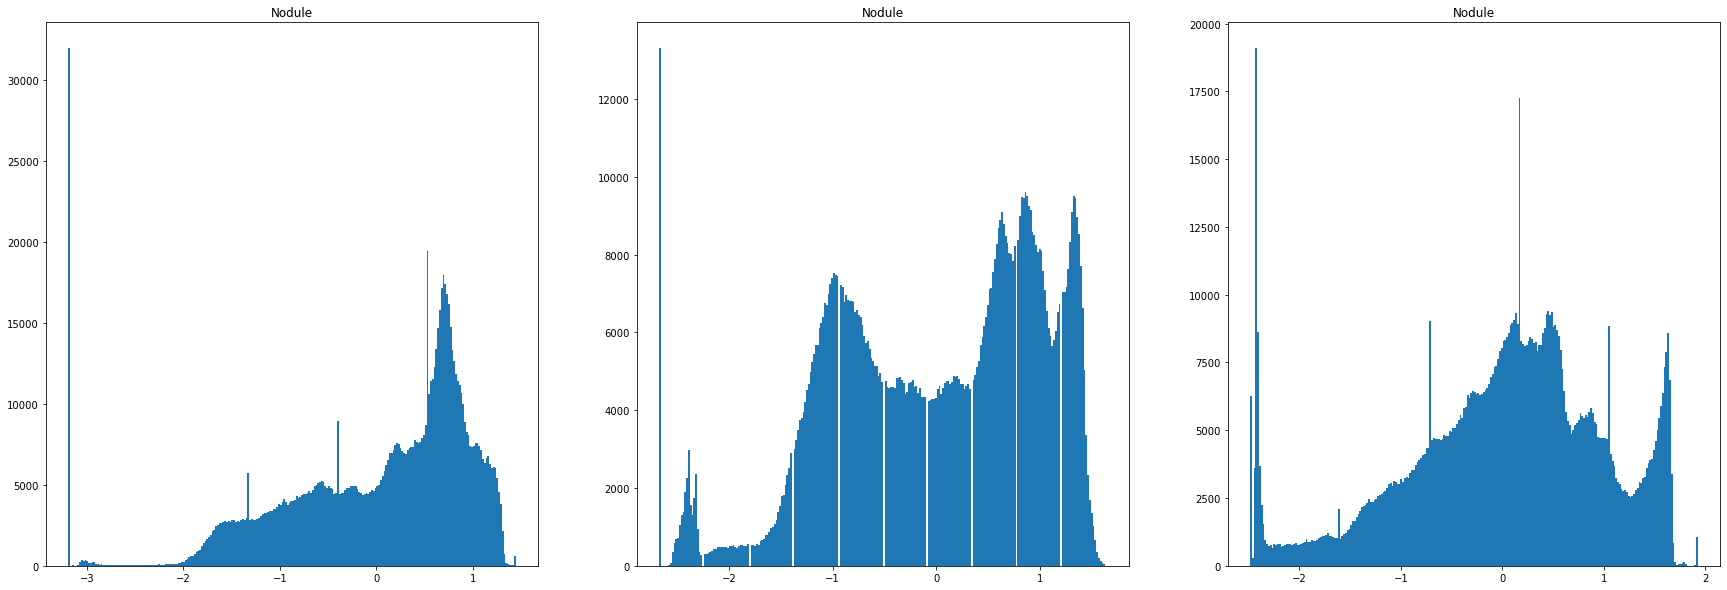

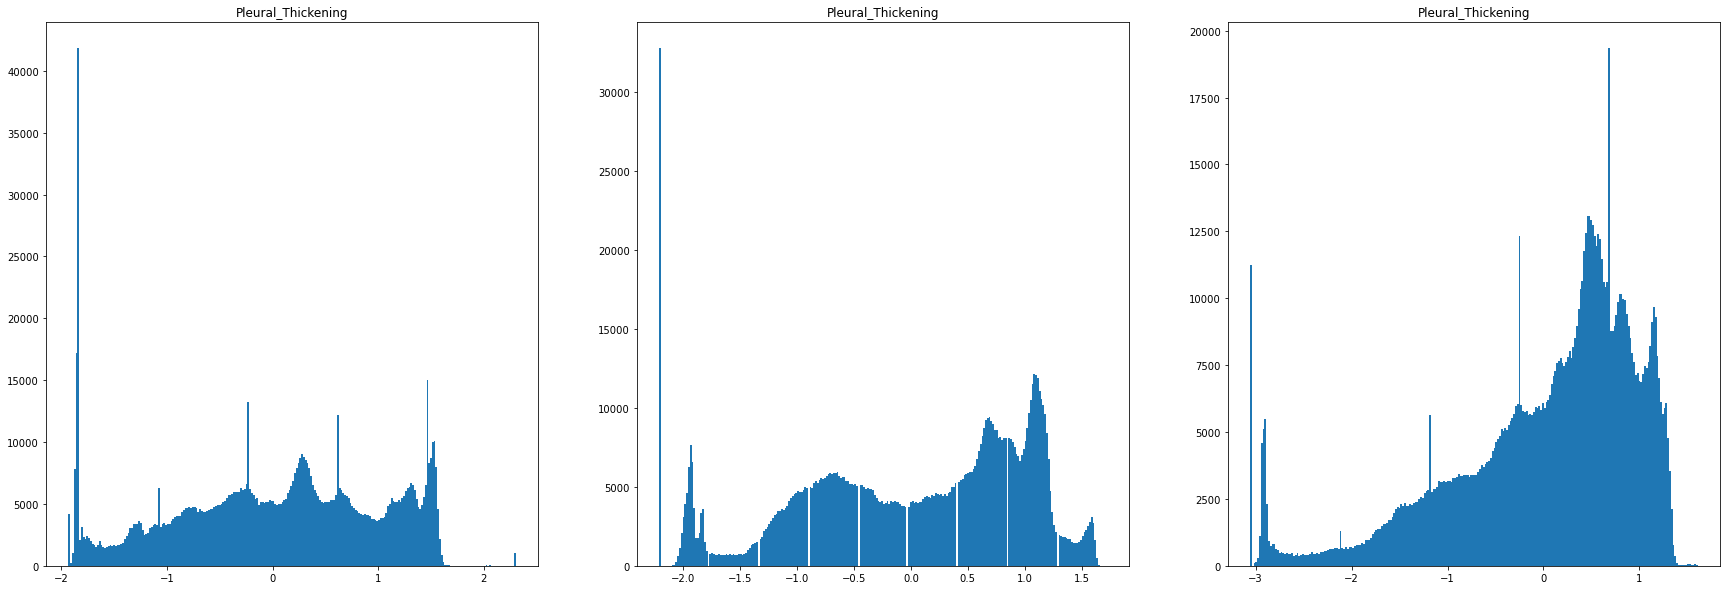

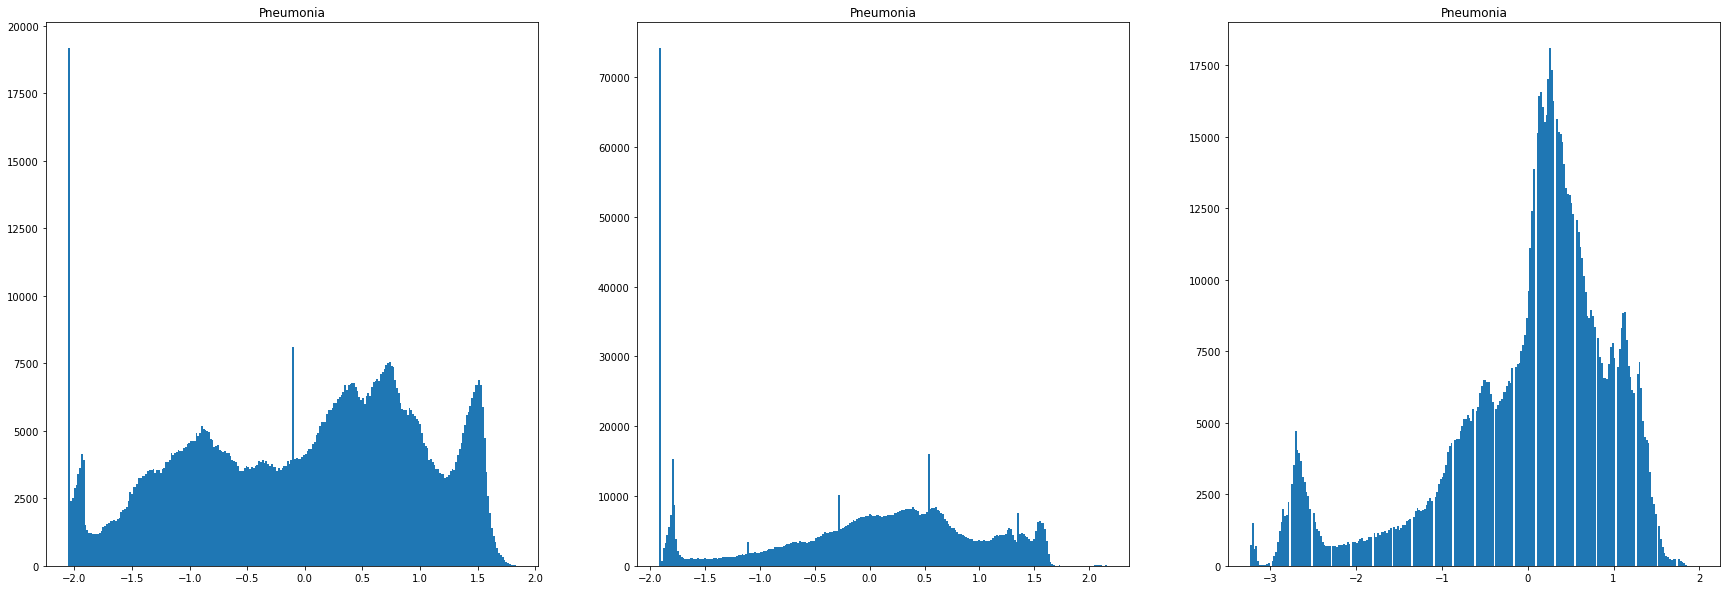

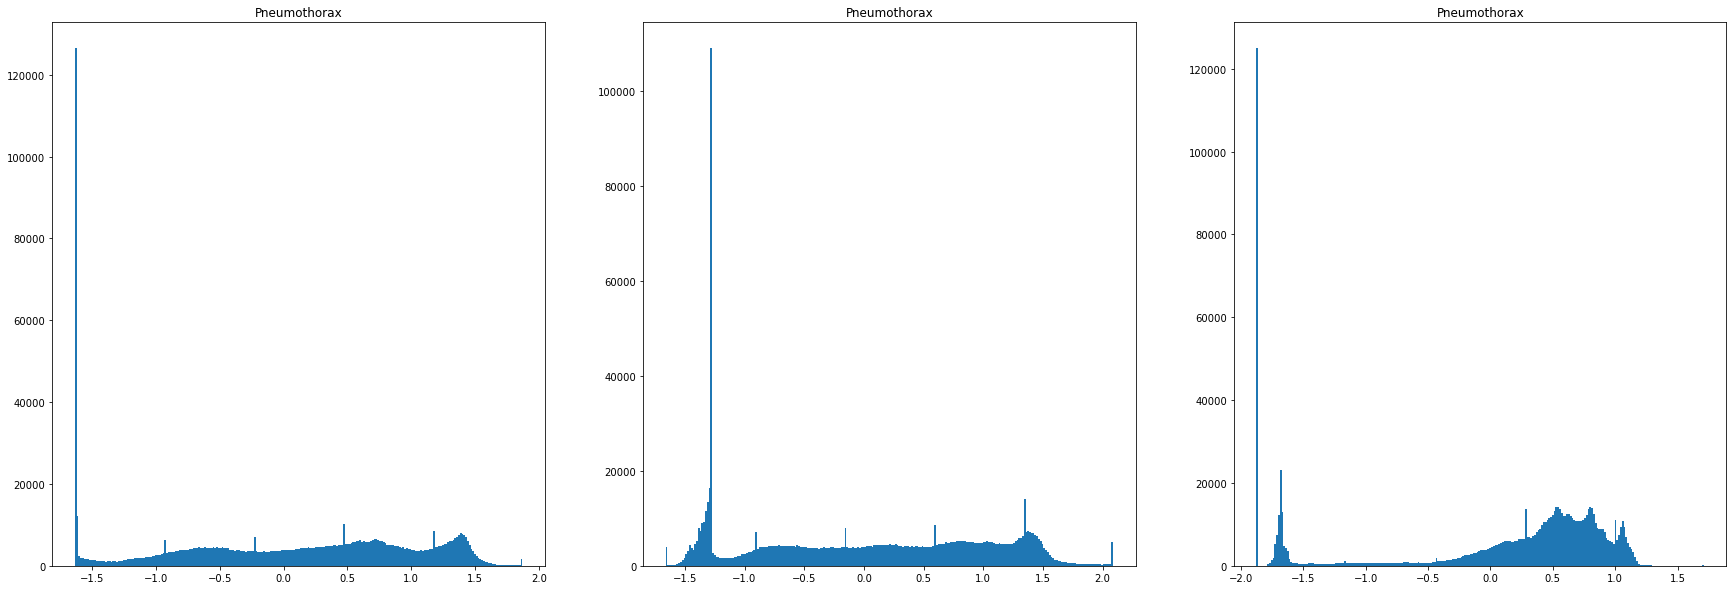

In [31]:
for item in sample_labels:
    img_path = sample_df[sample_df["Finding Labels"] == item].sample(3, random_state=random_state)["path"]
    plt.figure(figsize = (30, 10))
    for i in range(len(img_path)):
        plt.subplot(1, len(img_path), i + 1).set_title(item)
        var = plt.imread(img_path.iloc[i])
        plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

In [32]:
## Pneumonia 
img_path_pn = sample_df[sample_df["Finding Labels"] == 'Pneumonia'].sample(5, random_state=random_state)["path"]
Pneumonia_pixel_arr =  np.array([plt.imread(img_path_pn.iloc[i]) for i in range(len(img_path_pn.values))])
mean_intensity = np.mean([plt.imread(img_path_pn.iloc[i]) for i in range(len(img_path_pn.values))])
std_intensity = np.std([plt.imread(img_path_pn.iloc[i]) for i in range(len(img_path_pn.values))])
print(f"The mean value for Pneumonia is {mean_intensity}")
print(f"The std value for Pneumonia is {std_intensity}")

The mean value for Pneumonia is 0.513569712638855
The std value for Pneumonia is 0.23998945951461792


Text(0.5, 1.0, 'Pneumonia Pixel Intensity')

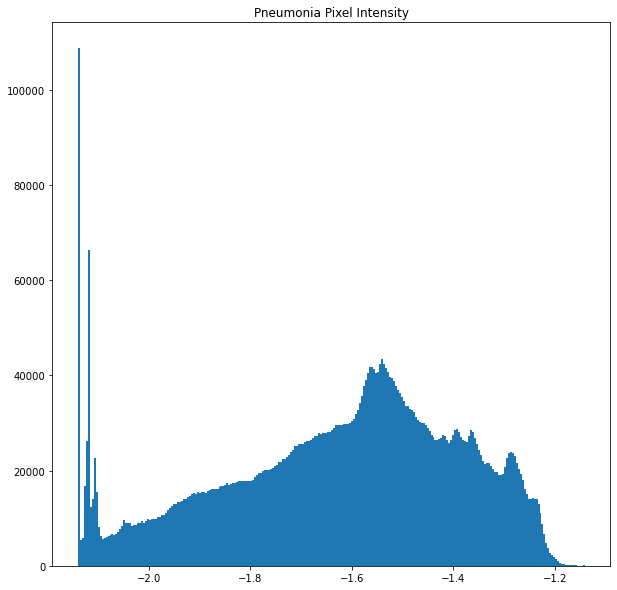

In [33]:
# For Pneumonia case
plt.figure(figsize=(10,10))
plt.hist((Pneumonia_pixel_arr -  np.mean(Pneumonia_pixel_arr)/np.std(Pneumonia_pixel_arr)).ravel(), bins = 256)
plt.title('Pneumonia Pixel Intensity')